In [38]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import KFold
import pickle

model_loc = "./Dataset/dtree_5_images.sav"

In [39]:
skin_dataset = pd.read_csv("./Dataset/pixelwise_skin_and_burn_5_images.csv")
skin_dataset = skin_dataset.dropna()
X = skin_dataset.iloc[:,:-1]
y = skin_dataset.iloc[:,-1]

In [40]:
is_NaN = X.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = X[row_has_NaN]

print(rows_with_NaN)
print(len(rows_with_NaN))

Empty DataFrame
Columns: [h, s, i]
Index: []
0


In [41]:
model_scores = []
models = []

kf =KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    print(X_train)
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]# split()  method generate indices to split data into training and test set.
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train.values, y_train.values)
    score = clf.score(X_test.values, y_test.values)
    models.append(clf)
    model_scores.append(score)

TRAIN: [     0      1      2 ... 249685 249686 249689] TEST: [     4      6     11 ... 249680 249687 249688]
               h         s         i
0       0.609986  0.321051  0.513726
1       0.632786  0.316226  0.521569
2       0.605891  0.328784  0.525490
3       0.605891  0.321589  0.537255
5       0.596468  0.332934  0.534641
...          ...       ...       ...
249993  4.049266  0.037134  0.818301
249994  4.049266  0.036956  0.822222
249995  4.049266  0.037134  0.818301
249996  3.990048  0.047395  0.806536
249999  3.990048  0.047861  0.798693

[199752 rows x 3 columns]
TRAIN: [     2      3      4 ... 249686 249687 249688] TEST: [     0      1     20 ... 249681 249682 249689]
               h         s         i
2       0.605891  0.328784  0.525490
3       0.605891  0.321589  0.537255
4       0.596468  0.332934  0.534641
5       0.596468  0.332934  0.534641
6       0.581916  0.341156  0.529412
...          ...       ...       ...
249994  4.049266  0.036956  0.822222
249995  4.04926

In [42]:
print(len(models))
print(model_scores)
max_value = max(model_scores)
max_index = model_scores.index(max_value)
pickle.dump(models[max_index], open(model_loc, 'wb'))
#print(len(models))

5
[0.8984540830629981, 0.900216268172534, 0.898333934078257, 0.8983739837398373, 0.8959509792142256]


In [43]:
loaded_model = pickle.load(open(model_loc, 'rb'))

In [44]:
test_img = "./Dataset/full_coco/images/img1.jpg"
from skin_segmentation import load_rgb_image
from converter import RGB_TO_HSI
import numpy as np

def segment_image(rgb_image):
    test_image_data = rgb_image.copy()
    test_image_hsi = RGB_TO_HSI(test_image_data)
    for row in range(0, test_image_hsi.shape[1]):
        for col in range(0, test_image_hsi.shape[0]):
            if np.isnan(test_image_hsi[row,col][0]):
                test_image_data[row,col] = (0, 0, 0)
                continue
            else:
                prediction = loaded_model.predict([test_image_hsi[row,col]])
                if prediction == 0:
                    test_image_data[row,col] = (0, 0, 0)
                elif prediction == 1:
                    test_image_data[row,col] = (125, 125, 125)
                elif prediction == 2:
                    test_image_data[row,col] = (250, 250, 250)
    return test_image_data

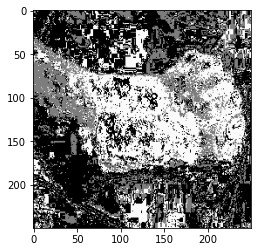

In [45]:
import matplotlib.pyplot as plt

rgb_image = load_rgb_image(test_img)
segmented_image = segment_image(rgb_image)
plt.imshow(segmented_image)
